In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, Callback
from tensorflow.keras.constraints import max_norm
from random import randint
from keras.utils import np_utils
import numpy as np
import random
import os
import re
import string
import glob
import sys
import io
print("GPU:", tf.test.gpu_device_name())

TensorFlow 2.x selected.
Tensorflow version: 2.0.0


Using TensorFlow backend.


GPU: /device:GPU:0


In [2]:
!git clone https://github.com/michalovsky/books_data.git

Cloning into 'books_data'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 76 (delta 20), reused 57 (delta 13), pack-reused 0
Unpacking objects: 100% (76/76), done.


In [3]:
# Read all text file paths from directory
directory1 = "books_data/kafka/"
directory2 = "books_data/shelley/"
directory3 = "books_data/defoe/"
directory4 = "books_data/plato/"

directory = directory1
file_paths = glob.glob(directory +"*.txt")    
print("Found", len(file_paths), "text files in directory:", directory)

Found 2 text files in directory: books_data/kafka/


In [4]:
# Extract text from all text files
text = ""

for file_path in file_paths:
    with open(file_path, 'r', encoding="utf-8-sig") as file:
        file_content = file.read()
        text+=file_content
print ('Length of text: {} characters'.format(len(text)))

Length of text: 571642 characters


In [5]:
# Preprocess data
chars_to_remove = '–—”„…«»‘’“°ſ†•✠' + '!\"#$%&\'()*+-/:;<=>?@[\]^_`{|}~' + string.digits
removal_translator = str.maketrans("", "", chars_to_remove)
special_characters_translator = str.maketrans('ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœï', 'acelnoszzaoueeeeoaaaeceinouuuaei', '')

# remove redundant characters and translate special characters
text = text.lower().translate(removal_translator).translate(special_characters_translator)

def split_punctuation_from_sentence(char):
	if (char == '.' or char == ','):
		return (" " + char + " ")
	else:
		return (char)
  
text = "".join( list( map( split_punctuation_from_sentence , text)))

#remove extra spaces and new lines
text = ' '.join(text.split())

unique_characters = sorted(list(set(text)))
print ('{} unique characters:'.format(len(unique_characters)))
print(unique_characters)

words = text.split()
print('Total words:', len(words))

vocab = sorted(set(words))
vocab_size = len(vocab)
print('Unique words:', vocab_size)

29 unique characters:
[' ', ',', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total words: 117176
Unique words: 5611


In [7]:
# organize into sequences of words and sequences of tokens

word_to_indices = dict((w, i) for i, w in enumerate(vocab))
indices_to_word = dict((i, w) for i, w in enumerate(vocab))
encoded_words = [word_to_indices[word] for word in words]

in_seq_length = 10
out_seq_length = 1
length = in_seq_length + out_seq_length

sequences = list()
tokens = list()
for i in range(length, len(words)):
	line = ' '.join(words[i-length:i])
	sequences.append(line)
	tokens.append(encoded_words[i-length:i])
print('Total Sequences:',  len(sequences))

print(sequences[:3])
print(tokens[:3])


Total Sequences: 117165
['one morning , when gregor samsa woke from troubled dreams ,', 'morning , when gregor samsa woke from troubled dreams , he', ', when gregor samsa woke from troubled dreams , he found']
[[3366, 3155, 0, 5443, 2192, 4163, 5522, 2050, 5115, 1507, 0], [3155, 0, 5443, 2192, 4163, 5522, 2050, 5115, 1507, 0, 2304], [0, 5443, 2192, 4163, 5522, 2050, 5115, 1507, 0, 2304, 2011]]


In [0]:
from sklearn.model_selection import train_test_split

data = np.asarray(tokens)
X, y = data[:,:-1], data[:,-1]
y = np_utils.to_categorical(y, num_classes=vocab_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [14]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=X.shape[1]))
model.add(LSTM(100, return_sequences=True, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
model.add(BatchNormalization())
model.add(LSTM(100, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
model.add(BatchNormalization())
model.add(Dense(vocab_size, activation='softmax'))

# from nltk.translate.bleu_score import sentence_bleu

# class BLEUScore(tf.keras.metrics.Metric):
#     def __init__(self, name='BLEU', **kwargs):
#         super(BLEUScore, self).__init__(name=name, **kwargs)
#         self.bleu = self.add_weight(name='bleu', initializer='zeros')

#     def convert_to_categorical(self, data):
#         data = tf.squeeze(data)
#         if tf.rank(data) == 1:      # already categorical data, only casting to int32
#             data_categorical = tf.cast(data, dtype=tf.int32)
#         else:                       # convert one-hot-encoding (softmax!!!!) to categorical    
#             data_categorical = tf.argmax(data, axis=1)
#             data_categorical = tf.cast(data_categorical, dtype=tf.int32)
#         return data_categorical

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         print(type(y_true))
#         y_true_categorical = self.convert_to_categorical(y_true)
#         y_pred_categorical = self.convert_to_categorical(y_pred)

#         # y_true = [indices_to_word[index] for index in y_true_categorical]
#         macro_bleu = sentence_bleu(y_true_categorical, y_pred_categorical)
#         self.bleu.assign(0)

#     def result(self):
#         return self.bleu 

#     def reset_states(self):
#         self.bleu.assign(0.)    
        
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 50)            280550    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 100)           60400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 100)           400       
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 5611)              566711    
Total params: 988,861
Trainable params: 988,461
Non-trainable params: 400
______________________________________________

In [0]:
from keras.preprocessing.sequence import pad_sequences

# generate a sequence from a language model
def generate_text(model, seq_length, seed_text, n_words):
	result = list()
	in_text = seed_text
	for _ in range(n_words):
		# encode the text as integer
		encoded = [word_to_indices[word] for word in in_text.split()]
		# truncate sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = indices_to_word[yhat[0]]
		in_text += ' ' + out_word
		result.append(out_word)
	
	result = ' '.join(result).replace(" ,", ",").replace(" .", ".")
	return result

In [16]:
# Callbacks

seed_text_for_epochs = sequences[randint(0,len(sequences))]
print("Checking with seed:", seed_text_for_epochs)

def on_epoch_end(epoch, _):
    print()
    print('Generated text:')
    print(generate_text(model, seq_length=in_seq_length, seed_text=seed_text_for_epochs, n_words=50))
    print()
    
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=50)


Checking with seed: to confirm what i say . i can see him now


In [17]:
callbacks = [ es, print_callback]

batch_size = 128
epochs = 100

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=callbacks)

Train on 93732 samples, validate on 23433 samples
Epoch 1/100

Generated text:
, said k, said the painter, he had been been to see the court. he had been been to see the court, he had been been to see the court. he had been been to see the court, he had been been to see

93732/93732 - 19s - loss: 5.9216 - accuracy: 0.1163 - val_loss: 5.1971 - val_accuracy: 0.1461
Epoch 2/100

Generated text:
, but he was unable to see the door of the door of the door and had been been in the room and had been been in the way of the door of the door and was a little time, and he had been seen the door of the

93732/93732 - 14s - loss: 4.7185 - accuracy: 0.1724 - val_loss: 5.0009 - val_accuracy: 0.1564
Epoch 3/100

Generated text:
, and then, and the two gentlemen were in the room. the man had been seen in the room, and the door of the room. the man had been standing in the room, and then, and the two gentlemen were in the room.

93732/93732 - 15s - loss: 4.3404 - accuracy: 0.2023 - val_loss: 4.9518 - va

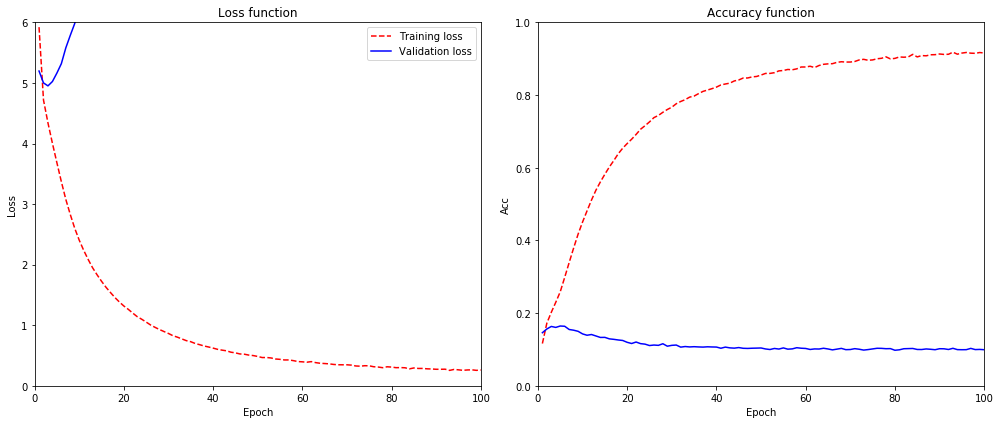

In [18]:
import matplotlib.pyplot as plt

# Make characteristics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)
# plt.savefig(save_directory+"/characteristics.png")  

plt.tight_layout()
plt.show()

In [24]:
# select a seed text
seq_length = X.shape[1]
seed_text = sequences[randint(0,len(sequences))]
print("Generating with seed:",seed_text, "\n")
 
# generate new text
generated = generate_text(model, seq_length, seed_text, 50)
print(generated)

Generating with seed: let him live in the living room next to you over 

the last few days. hes not very considerate. what an idea said k, in particular really, how to go on it, while grete before her left her arms around his fingers. mother she sister called her to the middle hold of the door to
